# Be a geoscience detective !

A second example where I look at a published case study correlating inversion data to petrophysical estimates of porosity-height in the the Doig and Montney Formations in Western Canada (from the paper [Tight gas geophysics: AVO inversion forreservoir characterization, Close et al. CSEG Recorder, May 2010](https://csegrecorder.com/articles/view/tight-gas-geophysics-avo-inversion-for-reservoir-characterization)

### License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />The code in this work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"> CC BY Creative Commons License</a>.

The figure used is copyright of the Canadian Society of Exploration Geophysicists (reproduced under the assumption of [Fair Use](https://fairuse.stanford.edu/overview/fair-use/what-is-fair-use/)).

### Preliminaries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import statsmodels.api as sm
from scipy import stats
from itertools import groupby
import seaborn as sns
from skimage import io
import dcor
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

###  Plot figure of interest from the paper

The authors indicate that Vp/Vs and/or Poisson’s ratio maps from seismic inversion are a good indicators of porosity in the LowerDoig and Upper Montney reservoirs in the wells used in their study, so it is reasonable to try to predict Phi-H from Vp/Vs via regression.

The figure below shows one such Vp/Vs ratio map and the Vp/Vs vs. Phi-H cross-plot for 8 wells.

In [5]:
url = 'https://csegrecorder.com/assets/images/articles/2010-05-tight-gas-geophys-fig07.jpg'
fig07=io.imread(url)

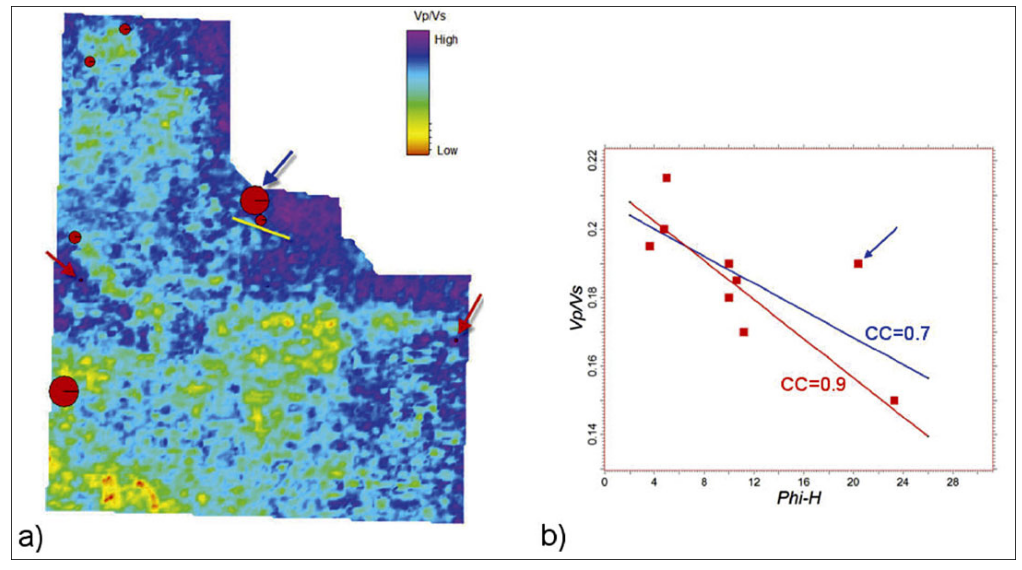

In [6]:
fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(fig07);

__Figure 7 caption__: _Figure 7. a) Map of median Vp/Vs ratio value and porosity-height from 8 wells through the Lower Doig and Upper Montney. The red arrows highlight wells with very small porosity-height values and correspond in general to areas of higher Vp/Vs ratio. The blue arrow highlights a well at the edge of the seismic data where the inversion is adversely affected by decreased fold. The yellow line is the approximate location of a horizontal well where micro-seismic data were recorded during stimulation. b) Cross-plot of porosity-height values as shown in (a) against Vp/Vs extracted from the map. The correlation co-efficient of all data points (blue line) of 0.7 is improved to 0.9 (red line) by removing the data point marked by the blue arrow which again corresponds to the well near the edge of the survey (a)._

### Take the data out of the figure

I hand-digitized the porosity-height and Vp/Vs pairs in the cross-plot in (b) above (using again [WebPlotDigitizer](https://apps.automeris.io/wpd/)).

In [7]:
data = pd.read_csv('data/VpVs_PhiH_digits.csv')
data

,Phi-h,Vp/Vs
0,23.270,0.1499
1,11.160,0.1698
2,9.986,0.1799
3,10.610,0.1849
4,10.020,0.1897
5,20.380,0.1897
6,3.653,0.1947
7,4.799,0.1998
8,4.968,0.2148


### Initial plot

First of all, I'd argue for switching the axes, since most likely the objective of any regression effort would be to predict as the dependent variable Phi-h, at the location of yet to drill wells, given Vp/Vs from seismic inversion.

I also lable the wells using their row index.

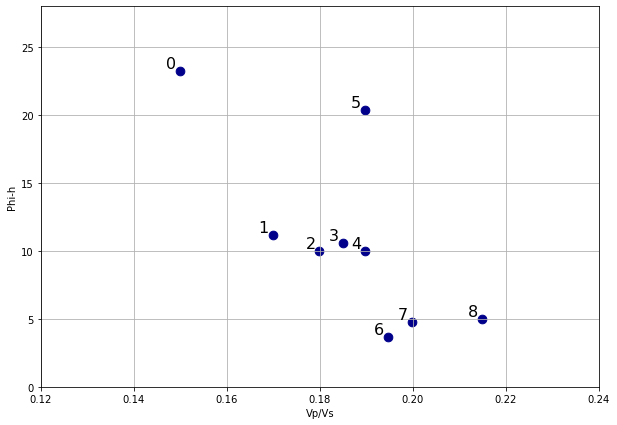

In [8]:
x = data['Vp/Vs'].values
y = data['Phi-h'].values
n = data.index.values

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(np.sort(x), y[np.argsort(x)], color = 'darkblue', s = 75)
ax.set_xlabel('Vp/Vs')
ax.set_xlim(0.12,0.24)
ax.set_ylabel('Phi-h')
ax.set_ylim(0,28)
plt.grid()

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]-0.003, y[i]+0.2), fontsize=16)
    
plt.show();

### OLS regression plot with outliers and leverage points

The authors show in the figure that by removing one of the data points, corresponding to a well near the edge of the survey (where the sesimic inversion result is presumably not as reliable, due to lower offset and azimuth coverage), the correlation co-efficient is improved from 0.7 to 0.9 (red line). This is the well labeled as 5 in my plot above.

Below I am using Ordidary Least Square Regression from the `statsmodels` library to make a similar plot.

In [9]:
no_outlier_data = data.drop(index=5)
no_outlier_data

,Phi-h,Vp/Vs
0,23.270,0.1499
1,11.160,0.1698
2,9.986,0.1799
3,10.610,0.1849
4,10.020,0.1897
6,3.653,0.1947
7,4.799,0.1998
8,4.968,0.2148


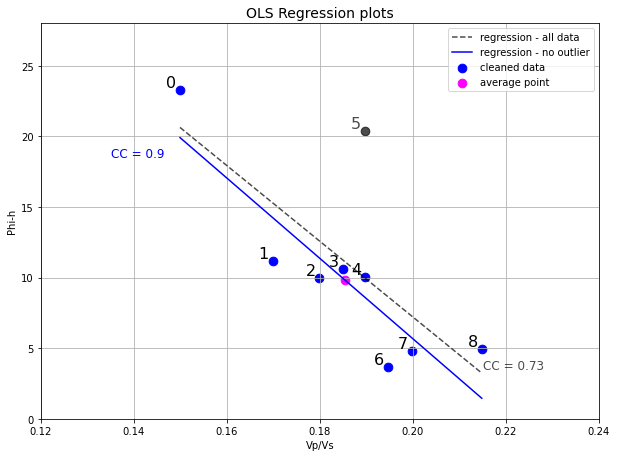

In [10]:
lm = sm.OLS(y, sm.add_constant(x)).fit()
x1 = no_outlier_data['Vp/Vs'].values
y1 = no_outlier_data['Phi-h'].values
n1 = no_outlier_data.index.values
lm1 = sm.OLS(y1, sm.add_constant(x1)).fit()

fig = plt.figure(figsize=(10,16))
ax1 = fig.add_subplot(211)

ax1.set_title('OLS Regression plots', fontsize=14)
ax1.scatter(np.sort(x1), y1[np.argsort(x1)], color = 'blue', s = 75, label='cleaned data')
ax1.scatter(np.mean(x1), np.mean(y1), color = 'magenta', s=75, label='average point')
ax1.scatter(x[5], y[5], color = 'k', alpha=0.7, s=75)
ax1.plot(np.sort(x), lm.predict()[np.argsort(x)], 'k--', alpha=0.7, label = 'regression - all data')
ax1.plot(np.sort(x1), lm1.predict()[np.argsort(x1)], color = 'blue', label = 'regression - no outlier')

ax1.legend()

ax1.text(0.135, 18.5, 'CC = '+ str(np.round(lm1.rsquared**0.5, 2)), fontsize=12, color = 'blue')
ax1.text(0.215, 3.5, 'CC = '+ str(np.round(lm.rsquared**0.5, 2)), fontsize=12, color = 'k', alpha=0.7)

ax1.set_xlabel('Vp/Vs')
ax1.set_xlim(0.12,0.24)
ax1.set_ylabel('Phi-h')
ax1.set_ylim(0,28)

for i, txt in enumerate(n1):
    ax1.annotate(txt, (x1[i]-0.003, y1[i]+0.2), fontsize=16)

ax1.annotate('5', (x[5]-0.003, y[5]+0.2), fontsize=16, color = 'k', alpha=0.7)
plt.grid()

So, I am able to reproduced the analysis from the figure. I think removing an outlier with insight from domain knowledge (the observation that poorer inversion result at this location is responsble for the deviation from trend) is a legitimate choice. 

However, I would like to dig a bit deeper, to back up the decision with other analyses and tests, and to show how one might do it with their own data. 

### Influence plot

The first thing to look at is the Influence plot, which is a plot of the residuals, scaled by their standard deviation, against the leverage, for each observation.

Influence plots are useful to [distinguish between high leverage observations from outliers](https://online.stat.psu.edu/stat462/node/170/) and are one  one of `statsmodel` 's standard [Regression plots](https://www.statsmodels.org/devel/examples/notebooks/generated/regression_plots.html#),  so we get the next figure almost for free, with minor modifications to the [default example](https://www.statsmodels.org/devel/examples/notebooks/generated/regression_plots.html#Influence-plots)).


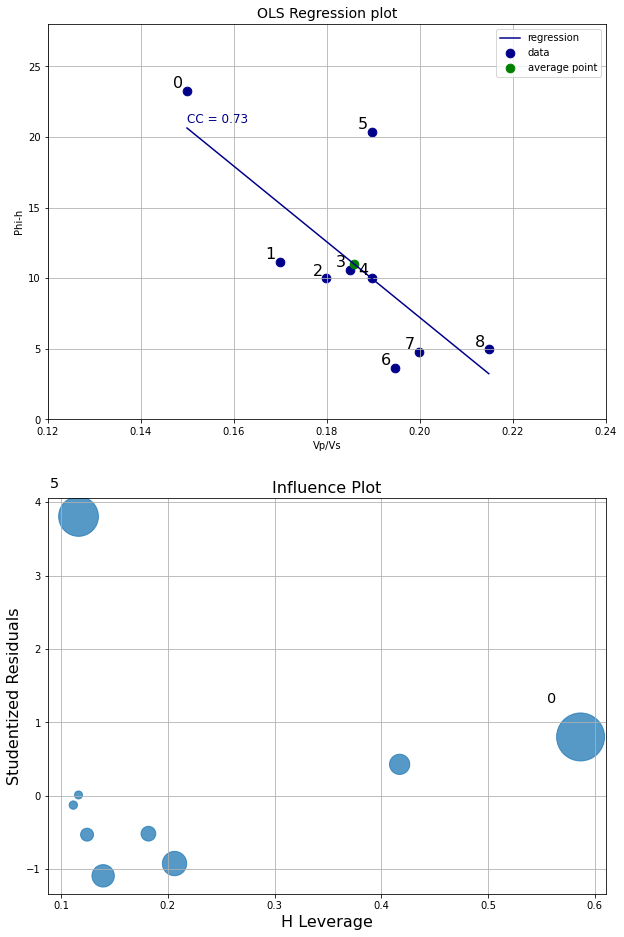

In [11]:
fig = plt.figure(figsize=(10,16))
ax1 = fig.add_subplot(211)

ax1.set_title('OLS Regression plot', fontsize=14)
ax1.scatter(np.sort(x), y[np.argsort(x)], color = 'darkblue', s = 75, label='data')
ax1.scatter(np.mean(x), np.mean(y), color = 'green', s=75, label='average point')
ax1.plot(np.sort(x), lm.predict()[np.argsort(x)], color = 'darkblue', label = 'regression')
ax1.legend()
ax1.text(0.15, 21, 'CC = ' + str(np.round(lm.rsquared**0.5, 2)), fontsize=12, color = 'darkblue')
ax1.set_xlabel('Vp/Vs')
ax1.set_xlim(0.12,0.24)
ax1.set_ylabel('Phi-h')
ax1.set_ylim(0,28)

for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i]-0.003, y[i]+0.2), fontsize=16)
    
plt.grid()

ax2 = fig.add_subplot(212)
sm.graphics.influence_plot(lm, alpha  = 0.05, ax = ax2, criterion='cooks')
plt.grid()
plt.show();

From this plot it is very obvious that the point labeled as zero has high leverage (but not high nrmalized residual), whereas the point labled as 5 has very high normalized residual. This point will influence the regression line, reducing the R^2 and correlation coefficient.

This analysis seems a good way to legitimize removing the outlier point. 

### Inferences about Linear Correlation

As I've written in an earlier notebook on [Data loading, visualization, significance testing](https://github.com/mycarta/Data-science-tools-petroleum-exploration-and-production/blob/master/Python/notebooks/Python_data_science_tools%20_petroleum_exploration_production.ipynb), I find the critical r very useful in the context of univariate analysis. 

The critical r is the value of the correlation coefficient at which you can rule out chance as an explanation for the relationship between variables observed in the sample, and I look at it in combination with the confidence interval of the correlation coefficient.

##### Function to round a float to the nearest 0.5 (From [this Stack Overflow answer](https://stackoverflow.com/a/4265592/1034648)).   
Used by `r_crit` function below.

In [12]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def round_to_05(n):
    return round_to(n, 0.05)

##### Function to calculate the critical r

In [13]:
def r_crit(nwells):
    """
    Function to calculate the value of critical correlation coefficient: 
    that is, the value of the correlation coefficient at which you can rule out chance as 
    an explanation for the relationship in the sample, given a confidence level of 95%.
    nwells-2 is the degrees of freedom.
    Reference: https://brownmath.com/stat/correl.htm#DecisionPoints
    
     Parameters
    ----------
    nwells: integer
        the number of wells
    
    Returns
    -------
    r_crit: formatted float
        The critical correlation coefficient
    """
    t = stats.t.isf(0.025, nwells-2) # nwells-2 is the degrees of freedom
    r_crit = t/np.sqrt((nwells-2)+ np.power(t,2))
    return float("{0:.2f}".format(r_crit))

##### Function to calculate the onfidence interval for the correlation coefficient

In [14]:
def confInt(r, nwells):
    """
    Function to calculate the confidence interval interval for the population
    correlation coefficient, given a confidence level of 95%, the number of
    wells (and from that the degrees of freedom), and the sample correlation coefficient.
    For the details of the calculation, see Brown at: http://brownmath.com/stat/correl.htm#CI
    Notice that the function can take directly arrays as parameters (broadcasting).
    Reference: https://brownmath.com/stat/correl.htm#CI
    
    Parameters
    ----------
    r: float
        the sample correlation coefficient   
    nwells: integer
        the number of wells
    
    Returns
    -------
    RCI_u, RCI_l: tuple
        The upper and lower limits of the confidence interval for the correlation coefficient
    """
    z_crit = stats.norm.ppf(.975)
    std_Z = 1/np.sqrt(nwells-3)
    E = z_crit*std_Z
    Z_star = 0.5*(np.log((1+r)/(1.0000000000001-r)))
    ZCI_l = Z_star - E
    ZCI_u = Z_star + E
    RCI_l = (np.exp(2*ZCI_l)-1)/(np.exp(2*ZCI_l)+1)
    RCI_u = (np.exp(2*ZCI_u)-1)/(np.exp(2*ZCI_u)+1)
    return RCI_u, RCI_l

### Plotting confidence interval and discussion

The next tow plots display in dark blue, and light blue, respectively, the upper and lower confidence interval bounds, as the correlation coefficient r varies between 0 and 1 (x axis). These two bounds will change with different number of wells (they will get closer with more wells, and farther apart with less wells). The lower bound intersects the x axis (y=0) axis at a value equal to the critical r (white dot). The green dots highlight the actual confidence interval for a specific correlation coefficient chosen, in this case 0.73 with 9 wells, and 0.9 with 8 wells.

<img src="https://mycarta.files.wordpress.com/2020/09/9wells.png" width="600"/>

<img src="https://mycarta.files.wordpress.com/2020/09/8wells.png" width="600"/>

### Discussion

With 9 wells, and cc=0.73, the resulting critical r = 0.67 tells us that for a 95% confidence level (0.05 alpha) we need at least a correlation coefficient of 0.67 in the sample (the 9 wells drilled) to be able to confidently say that there is correlation in the population (e.g. any well, future wells).

However, the confidence interval is quite broad, ranging between 0.13 and 0.94 (you can get these numbers by running `confInt(0.73, 9)` in a cell.


With 8 wells (having removed the outtlier), CC=0.9, the critical r is now 0.71, meaning that the requirement for rejecting the the null hypothesis (there is no association between Vp/Vs and Phi-H) is now a bit higher.

However, a CC increased to 0.9, and only one less well, also results in a confidence interval ranging from 0.53 to 0.98, hence our confidence is greatly increased. 

This also corroborates the idea that it is a good choice to remove the outlier.

### Interactive visualization

The plots above were screen captures from the interactive tool I built taking advantage of the Jupyter interactive functionality (`ipywidgets`). You can try it too below.

##### Define the function to do all the interactive plotting and also output array

In [15]:
def conf_int_demo(r, nwells):
    """
    Interactive plot of the relationship between the observed (user
    input)  sample correlation coefficient, the critical r, and the
    confidence interval for the population correlation coefficient,
    given a confidence level of 95%, and a user selected number of wells 
    (from which the degrees of freedom are calculated).  
    """

    ###### set up variables ######
    crr = np.arange(0.0,1.02,0.02).round(decimals=2)
    cm = np.asarray(confInt(crr, nwells))
    cm_test = np.asarray(confInt(r, nwells))

    ###### set up figure ######
    fig, ax = plt.subplots(figsize=(12,15))
    plt.title('Confidence interval for the correlation coefficient - ' + str(nwells) 
              + ' wells - 95% confidence level')
    ax.set_ylim([-1.05,1.05])
    ax.set_xlim([0, 1])
    ax.set_ylabel('R', rotation = 0)
    ax.set_xlabel('r', rotation = 0)

    ###### plot reference lines, R = 0 and R = r ######
    ax.plot([0,1], [0, 1], 'k', linewidth= 3, alpha = 0.7)
    ax.plot([0,1], [0, 0], 'k', linewidth= 3, alpha = 0.7)
    
    
    ###### Plot CI upper and lower limits ######
    ax.plot(np.arange(0.00,1.02,0.02), cm[0,:],  'darkblue', linewidth= 4, alpha = 0.8, 
            label = ('CI - upper bound'))
    ax.plot(np.arange(0.00,1.02,0.02), cm[1,:], 'royalblue', linewidth= 4, alpha = 0.8, 
            label = ('CI - lower bound'))
    
    ###### Plot MINIMUM and MAXIMUM R points ######
    ax.scatter (r, cm_test[0], s=180, facecolors = 'g', edgecolors='k', 
                label = 'MAX R (' + str(nwells) + ' wells, CC = ' 
                + '{:.2f}'.format(r) + ')', zorder=10)
    if cm_test[1]>= 0:
        ax.scatter (r, cm_test[1], s=200, facecolors = 'g', edgecolors='k', 
                    label = 'MIN R (' + str(nwells) + ' wells, CC = ' 
                    + '{:.2f}'.format(r) + ')',  zorder=10)
        ax.vlines( r, ymin=cm_test[1], ymax=cm_test[0], colors='g', 
                  linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=-1.05, ymax=cm_test[1], colors='k', linestyles='dotted', linewidth= 2)
    else:
        ax.scatter (r, cm_test[1], s=200, facecolors = 'm', edgecolors='k', 
                    label = 'MIN  R (' + str(nwells) + ' wells, CC = ' 
                    + '{:.2f}'.format(r) + ')', zorder=10)  
        ax.vlines(r, ymin=0, ymax=cm_test[0], colors='g', linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=cm_test[1], ymax=0, colors='m', linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=-1.05, ymax=cm_test[1], colors='k', linestyles='dotted', linewidth= 2)

    # plot critical r point
    ax.scatter (r_crit(nwells), 0, s=200, facecolors = 'w', edgecolors='k', 
                label = 'Critical CC = ' + '{:.2f}'.format(r_crit(nwells)), zorder=10)

    plt.legend(loc=4)
    plt.grid()
    plt.show()

#### Call the function and display the interactive plot

In [16]:
np.seterr(over='ignore')
rslt = interactive(conf_int_demo, r=FloatSlider(min=0, max=1.0, step=0.01, value = 0.73), 
                   nwells = IntSlider(min=4, max=20, step=1, value = 9))

In [17]:
display(rslt)

interactive(children=(FloatSlider(value=0.73, description='r', max=1.0, step=0.01), IntSlider(value=9, descrip…

### Distance correlation and p-value

As a last test, I used the distance correlation (`dcor.distance_correlation`) and p-value (`dcor.independence.distance_covariance_test`) from the dcor library.  I have written before in a [blog post](https://mycarta.wordpress.com/2019/04/10/data-exploration-in-python-distance-correlation-and-variable-clustering/) how much I like the distance correlation, because it does not assume a linear relationship between variables, and because a distance correlation of zero does mean that there is no dependence between those two variables (contrary to Pearson and Spearman).

In this case the relationship seems to be linear, but it is still a valuable test to compare DC and ppvalue before and after removing the outlier.

In [18]:
dc = np.round(dcor.distance_correlation(x, y), 3)

In [19]:
pv = np.round(dcor.independence.distance_covariance_test(x, y, exponent=1.0, num_resamples=5000)[0], 5)

In [20]:
print ('All data points:')
print ( 'D.C. = ', dc)
print ( 'p-value = ', pv)

All data points:
D.C. =  0.745
p-value =  0.03939


In [21]:
dc1 = np.round(dcor.distance_correlation(x1, y1), 3)

In [22]:
pv1 = np.round(dcor.independence.distance_covariance_test(x1, y1, exponent=1.0, num_resamples=5000)[0], 5)

In [23]:
print ('Data without outlier:')
print ( 'D.C. = ', dc1)
print ( 'p-value = ', pv1)

Data without outlier:
D.C. =  0.917
p-value =  0.0012


The distacne correlation values are very similar to the correlation coefficients from OLS, again going up once removed the outlier.

But, more interestingly, with all data points, a p-value of 0.04079 is very close to the alpha of 0.05, whereas once we removed the outlier, the p-value goes down by a factor of 20, to 0.0018.